## **Approach**


The dataset is open source for a **fashion ecommerce**.
The dataset columns definitions are:

**User ID**: This column contains a unique identifier for each user who interacted with the e-commerce platform. It could be a numerical ID or a hashed value to protect user privacy.

**Product ID**: This column contains a unique identifier for each product listed on the platform. Similar to User ID, it might be a numerical ID.

**Product Name**: This column specifies the name of the product. It should provide a clear description of the item.

**Brand**: This column indicates the brand associated with the product.

**Category**: This column categorizes the product into a broader group. This helps users browse and filter products based on their type (e.g., Women's Fashion, Men's Fashion, Kid's Fashion).

**Price**: This column represents the price of the product, likely in the currency used by the e-commerce platform.

**Rating**: This column contains an average rating or score that users have given to the product. This value could be on a specific scale (e.g., 1-5 stars) or a decimal value.

**Color**: This column specifies the color of the product.

**Size**: This column indicates the size of the product, which is relevant for apparel, footwear, or other items with size variations.



**The Approach Here we apply is as follow:**



*   We will recommend productID by content base filtering
*   We will recommend ProductID using USERID by collaborative filtering
*   Later we combine both the recommendations and create the Hybrid recommendations of PorductIDs i.e. recommending the ProductID by both productID(content based filtering) and ProductID(collaborative filtering) using USERID.
*   In the final result you will ask the Top10 recommended ProductIDs For a particular USERID.



In [ ]:
pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3162990 sha256=0eb79dea286621846d6e2fbad7b00a19d83f9e48162ba314ec0f54eb77f87027
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
from surprise import Dataset, Reader, SVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pandas as pd

In [ ]:
data = pd.read_csv("fashion_products.csv")
data.head(10)

,User ID,Product ID,Product Name,Brand,Category,Price,Rating,Color,Size
0,19,1,Dress,Adidas,Men's Fashion,40,1.043159,Black,XL
1,97,2,Shoes,H&M,Women's Fashion,82,4.026416,Black,L
2,25,3,Dress,Adidas,Women's Fashion,44,3.337938,Yellow,XL
3,57,4,Shoes,Zara,Men's Fashion,23,1.049523,White,S
4,79,5,T-shirt,Adidas,Men's Fashion,79,4.302773,Black,M
5,98,6,Dress,Adidas,Men's Fashion,47,1.379566,Yellow,L
6,16,7,Jeans,Gucci,Men's Fashion,37,1.356750,White,XL
7,63,8,Sweater,Zara,Kids' Fashion,64,4.360303,Blue,XL
8,96,9,Sweater,H&M,Men's Fashion,53,4.466182,Green,XL
9,36,10,T-shirt,Zara,Kids' Fashion,55,4.093234,White,XL


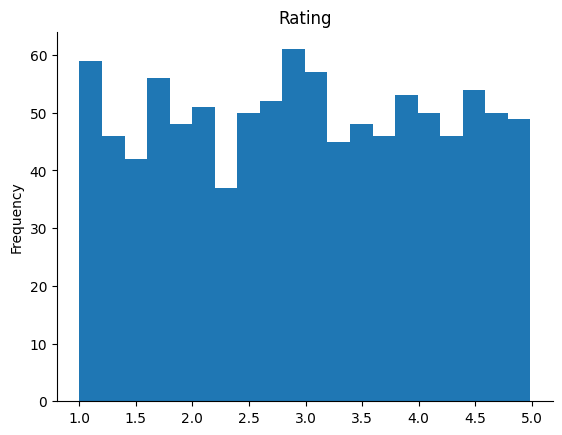

In [ ]:
# Rating

from matplotlib import pyplot as plt
data['Rating'].plot(kind='hist', bins=20, title='Rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

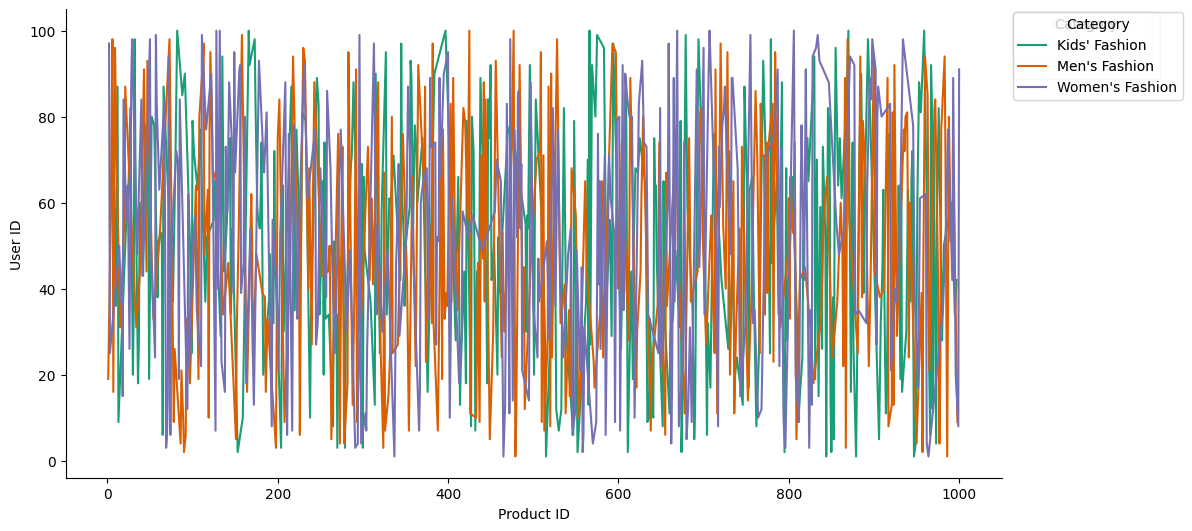

In [ ]:
# Product ID vs User ID

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Product ID']
  ys = series['User ID']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Product ID', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Category')):
  _plot_series(series, series_name, i)
  fig.legend(title='Category', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Product ID')
_ = plt.ylabel('User ID')

In [ ]:
data.isnull().sum()

User ID         0
Product ID      0
Product Name    0
Brand           0
Category        0
Price           0
Rating          0
Color           0
Size            0
dtype: int64

In [ ]:
# Content-Based Filtering
content_df = data[['Product ID', 'Product Name', 'Brand',
                   'Category', 'Price','Color', 'Size']]
content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# TF-IDF vectorizer to convert content into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer()
content_matrix = tfidf_vectorizer.fit_transform(content_df['Content'])

content_similarity = linear_kernel(content_matrix, content_matrix)

#Load the data into suprise object
reader = Reader(rating_scale=(1, 5))

#creating the data for collaborative filtering because its a
#User behavior data
data = Dataset.load_from_df(data[['User ID',
                                  'Product ID',
                                  'Rating']], reader)



<ipython-input-7-44cd93b71c7f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  content_df['Content'] = content_df.apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)


In [ ]:
#Creating a function for content basaed filtering
def get_content_based_recommendations(product_id, top_n):
    '''
    args:
    product_id (int): This argument represents the unique identifier of the product for which you want to generate recommendations.
    top_n (int): This argument specifies the number of most similar products to recommend (e.g., top_10 recommendations).

    output:
    recommendations (list of int): This function returns a list containing the unique product IDs of the top_n most similar products to the specified product_id.
    '''
    index = content_df[content_df['Product ID'] == product_id].index[0]
    similarity_scores = content_similarity[index]
    similar_indices = similarity_scores.argsort()[::-1][1:top_n + 1]
    recommendations = content_df.loc[similar_indices, 'Product ID'].values
    return recommendations


In [ ]:
#Recommending the top10 similar ProductIDs Based on Content
get_content_based_recommendations(5, 10)


array([  79, 1000,  243,  656,  208,  923,  644,  754,  221,  989])

In [ ]:
# Collaborative Filtering

from surprise.model_selection import cross_validate
from surprise.dump import dump
algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE','MSE','FCP'], cv=5, verbose=True)

trainset = data.build_full_trainset()
algo.fit(trainset)
model_filename = 'trained_model.pkl'
dump(model_filename, algo=algo)


Evaluating RMSE, MAE, MSE, FCP of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1571  1.2277  1.2076  1.1488  1.1579  1.1798  0.0317  
MAE (testset)     0.9889  1.0506  1.0605  0.9680  0.9963  1.0129  0.0362  
MSE (testset)     1.3388  1.5072  1.4583  1.3196  1.3408  1.3930  0.0753  
FCP (testset)     0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  
Fit time          0.04    0.03    0.04    0.02    0.02    0.03    0.01    
Test time         0.01    0.00    0.00    0.00    0.01    0.00    0.00    


In [ ]:
def get_collaborative_filtering_recommendations(algo,user_id, top_n):
    '''
    args:
    algo (surprise.prediction_algorithms.algo_base.AlgoBase): This argument represents a trained collaborative filtering algorithm from the Surprise library, used to generate predictions for user-item pairs.
    user_id (int): This argument specifies the unique identifier of the user for whom you want to get recommendations.
    top_n (int): This argument indicates the number of top recommended items to return.

    output:
    recommendations (list of int): This function returns a list containing the unique item IDs of the top_n items predicted to be most relevant for the given user_id.
    '''
    testset = trainset.build_anti_testset()
    testset = filter(lambda x: x[0] == user_id, testset)
    predictions = algo.test(testset)
    predictions.sort(key=lambda x: x.est, reverse=True)
    recommendations = [prediction.iid for prediction in predictions[:top_n]]
    return recommendations

In [ ]:
from surprise.dump import load

loaded_model = load(model_filename)[1]

In [ ]:
#Recommending the top10 similar USERIDs Based on collaboration
get_collaborative_filtering_recommendations(loaded_model,79,10)

[104, 998, 29, 972, 324, 920, 697, 800, 502, 190]

In [ ]:
# Hybrid Approach
def get_hybrid_recommendations(user_id, product_id, top_n):
    '''
    args:
    user_id (int): The unique identifier of the user for whom recommendations are generated.
    product_id (int): The unique identifier of a product to be used for content-based filtering.
    top_n (int): The desired number of top recommendations to return.

    Output:
    hybrid_recommendations (list of int): This function returns a list containing the unique product IDs of the top top_n items recommended using the hybrid approach.
    '''
    content_based_recommendations = get_content_based_recommendations(product_id, top_n)
    collaborative_filtering_recommendations = get_collaborative_filtering_recommendations(loaded_model,user_id, top_n)
    hybrid_recommendations = list(set(content_based_recommendations + collaborative_filtering_recommendations))
    return hybrid_recommendations[:top_n]


In [ ]:
user_id = 98
product_id = 6
top_n = 10
recommended_items = get_hybrid_recommendations(user_id, product_id, top_n)

print(f"Hybrid Recommendations for User {user_id} based on Product {product_id}:")
for i, recommendation in enumerate(recommended_items):
    print(f"{i + 1}. Product ID: {recommendation}")

Hybrid Recommendations for User 98 based on Product 6:
1. Product ID: 1216
2. Product ID: 1250
3. Product ID: 1090
4. Product ID: 778
5. Product ID: 619
6. Product ID: 1166
7. Product ID: 497
8. Product ID: 657
9. Product ID: 1875
10. Product ID: 279


In [ ]:
dataagain = pd.read_csv("fashion_products.csv")

In [ ]:
def get_user_recommendations(data,top_n):

  i=0
  user_recommendations = []
  for user_id in data['User ID'].unique():
    product_id = dataagain[dataagain['User ID']==user_id]['Product ID'].iloc[0]
    recom = get_hybrid_recommendations(user_id, product_id, top_n)
    user_recommendations.append(recom)
    i+=1
    if i==50:
      break


    # # Get user's rating history
    # user_ratings = data[data['user_id'] == user_id]
    # user_ratings = user_ratings.set_index('item_id')['rating']

    # # Exclude user's own ratings for similarity calculation
    # user_ratings = user_ratings.dropna()

    # # Collect recommended items (excluding already rated items)
    # recommended_items = []
    # for neighbor in neighbors:
    #   neighbor_ratings = data.loc[data['user_id'] == neighbor]['item_id'].tolist()
    #   for item_id in neighbor_ratings:
    #     if item_id not in user_ratings.index.tolist():
    #       recommended_items.append(item_id)

    user_recommendations.append(recommended_items)

  return user_recommendations

In [ ]:
recommended_items_lists = get_user_recommendations(dataagain,10)

In [ ]:
dataagain[dataagain['User ID']==98]['Product ID'].iloc[0]

6

In [ ]:
def calculate_precision_recall(data, recommended_items, k):

  user_precisions = {}
  user_recalls = {}
  for i in range(len(recommended_items)):
    user_id = data.loc[i, 'User ID']
    rated_items = list(data[data['User ID'] == user_id]['Product ID'])
    recommendations = recommended_items[i][:k]  # Consider only top k recommendations

    # Count relevant items in recommendations
    relevant_recommended = len(set(recommendations) & set(rated_items))

    # Calculate precision and recall
    total_recommendations = k
    total_rated_items = len(rated_items)
    user_precisions[user_id] = relevant_recommended / total_recommendations if total_recommendations > 0 else 0.0
    user_recalls[user_id] = relevant_recommended / total_rated_items if total_rated_items > 0 else 0.0

  # Calculate average precision and recall
  average_precision = sum(user_precisions.values()) / len(user_precisions)
  average_recall = sum(user_recalls.values()) / len(user_recalls)

  return {'precision': average_precision, 'recall': average_recall, 'user_precisions': user_precisions, 'user_recalls': user_recalls}

# Example usage: Calculate precision and recall at K=10
results = calculate_precision_recall(dataagain.copy(), recommended_items_lists, k=10)
print(f"Average Precision@5: {results['precision']:.2f}")
print(f"Average Recall@5: {results['recall']:.2f}")


Average Precision@5: 0.01
Average Recall@5: 0.01


In [ ]:
list(data[data['User ID'] == 98]['Product ID'])

[6, 29, 32, 50, 73, 173, 473, 528, 694, 779, 869, 893, 898, 934]

In [ ]:
rated_items = list(data[data['User ID'] == 19]['Product ID'])
recommendations = recommended_items_lists[0][:10]  # Consider only top k recommendations

# Count relevant items in recommendations
relevant_recommended = len(set(recommendations) & set(rated_items))


In [ ]:
relevant_recommended

0


# **Final Findings**
*   For ClickThroughrate and ConversionRate we can make a USER table where we can have ID(int), Recommendations list(array), Purchase (Boolean), Click(Boolean). After Having This table we can apply calculation for CR= Count(PurchaseTrue)/Count(USERID) * 100 and CTR= Count(ClickTrue)/Count(USERID) * 100

* Because its a Hybrid Recommendation so Currently predictions are Based on one productID for Every USERID, We can enhance these by considering all the productIDS for every USERID. In the dataset there are more than one ProductIDS for every USERID.

* We can USE Other techniques to Improve the performance, for example, Tensorflow, KNN, Hyperparameter Tuning, Feature engineering, Model Ensembling Etc.

* A/B testing is fine approach to find the customer segmentation and see which model is performing well in which scenario.

* Precision and Recall can be improve by tweaking with the formula for this model, right now the calculation is not perfecet for these 2 variables.

* We can increase precision and decrease the recall to have more accurate results by applying more techniques

* We can decrease RMSE and MAE to reach to 0 , and calculate R^2 close to 1 to make model more accurate.


